In [600]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score

import torchvision.datasets as ds
from torchvision import transforms
import torch
import pickle
import seaborn as sns


torch.manual_seed(94)

#set seed for reproducibility
np.random.seed(94)

Implement Base Layer

In [567]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input,isTrain):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

Implement Dense Layer

In [568]:
# np.random.seed(94)
class DenseLayer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        # print('input shape: ====',self.input.shape)
        # print('weights shape: ====',self.weights.shape)
        # print('bias shape: ====',self.bias.shape)
        output = np.dot(self.weights,self.input) + self.bias
        return output

    def backward(self, output_gradient, learning_rate):
        input_gradient = np.dot(self.weights.T,output_gradient)
        weights_gradient = np.dot(output_gradient,self.input.T)

        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient

        return input_gradient

Implement Activation Layer

In [569]:
# class Activation(Layer):
#     def __init__(self, activation, activation_prime):
#         self.activation = activation
#         self.activation_prime = activation_prime

#     def forward(self, input,isTrain=True):
#         self.input = input
#         output = self.activation(self.input)
#         return output
    
#     def backward(self, output_gradient, learning_rate):
#         return np.multiply(output_gradient,self.activation_prime(self.input))

In [570]:
class ReLu(Layer):
    def __init__(self):
        self.input = None

    def forward(self, input,isTrain=True):
        self.input = input
        return np.maximum(0,self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient,np.where(self.input>0,1,0))

Implement Activation function

In [571]:
# class ReLu(Activation):
#     def __init__(self):
#         def relu(x):
#             return np.maximum(0,x)
#         def relu_prime( x):
#             return np.where(x > 0, 1, 0)
#         super().__init__(relu, relu_prime)

Implement Softmax layer

In [572]:
class Softmax(Layer):
    def forward(self, input,is_Train=True):
        tmp = np.exp(input-np.max(input, axis=1, keepdims=True))
        self.output = tmp / np.sum(tmp, axis=1, keepdims=True)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        # batch_size = self.output.shape[0]
        # print('batch_size: ====',batch_size)
        # print('output_gradient shape: ====',output_gradient.shape)
        gradients = np.zeros_like(output_gradient)
        for index, (single_output_gradient, single_output) in enumerate(zip(output_gradient, self.output)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            gradients[index] = np.dot(jacobian_matrix, single_output_gradient)
    
        return gradients

Implement Dropout Layer

In [573]:
class Dropout(Layer):
    def __init__(self, rate):
        self.rate = 1-rate
        self.mask = None

    def forward(self, input,isTrain=True):
        if not isTrain:
            return input
        self.mask = np.random.binomial(1, self.rate, size=input.shape) / self.rate
        return input * self.mask

    def backward(self, output_gradient, learning_rate):
        return output_gradient * self.mask

Implement dense layer with adam optimizer

In [574]:
class AdamLayer(Layer):
    def __init__(self, input_size, output_size):

        self.weights = np.random.randn( input_size,output_size) * np.sqrt(2. / input_size)
        self.bias = np.random.randn(1,output_size)
        self.m_weights = np.zeros_like(self.weights)
        self.v_weights = np.zeros_like(self.weights)
        self.m_bias = np.zeros_like(self.bias)
        self.v_bias = np.zeros_like(self.bias)
        self.t = 0

    def forward(self, input,isTrain=True):
        self.input = input
        #check if input is nan
        # if np.isnan(self.input).any():
        #     print('input is nan in adam')
        #     print('input shape: ====',self.input.shape)
        #     print('weights shape: ====',self.weights.shape)
        #     print('bias shape: ====',self.bias.shape)
            # exit()
        #check if weights is nan
        # if np.isnan(self.weights).any():
        #     print('weights is nan in adam')
        #     print('input shape: ====',self.input.shape)
        #     print('weights shape: ====',self.weights.shape)
        #     print('bias shape: ====',self.bias.shape)
            # exit()
        #check if bias is nan
        # if np.isnan(self.bias).any():
        #     print('bias is nan in adam')
        #     print('input shape: ====',self.input.shape)
        #     print('weights shape: ====',self.weights.shape)
        #     print('bias shape: ====',self.bias.shape)
            # exit()
        output = np.dot(self.input,self.weights) + self.bias
        #check if output is nan
        # if np.isnan(output).any():
        #     print('output is nan in adam')
        #     print('input shape: ====',self.input.shape)
        #     print('weights shape: ====',self.weights.shape)
        #     print('bias shape: ====',self.bias.shape)
        #     print('output shape: ====',output.shape)
            # exit()
        return output

    def backward(self, output_gradient, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-7):
        weights_gradient = np.dot(self.input.T,output_gradient)
        bias_gradient = np.sum(output_gradient,axis=0,keepdims=True)

        self.t += 1  # Increment Time Step

        # if np.isnan(output_gradient).any():
        #     print('output_gradient is nan in adam backward >>>>>>>>>>>>')
        #     print('input shape: ====',self.input.shape)
        #     print('weights shape: ====',self.weights.shape)
        #     print('bias shape: ====',self.bias.shape)
        #     print('output_gradient shape: ====',output_gradient.shape)
            # exit()

        # Compute biased first moment estimate for weights
        self.m_weights = beta1 * self.m_weights + (1. - beta1) * weights_gradient
        # Compute biased second raw moment estimate for weights
        self.v_weights = beta2 * self.v_weights + (1. - beta2) * np.square(weights_gradient)

        # Compute bias-corrected first moment estimate for weights
        m_hat_weights = self.m_weights / (1. - np.power(beta1, self.t))
        # if np.isnan(self.m_weights).any():
        #     print('self_m_weights is nan in adam backward >>>>>>>>>>>>')
        #     print('input shape: ====',self.input.shape)
        #     print('weights shape: ====',self.weights.shape)
        #     print('bias shape: ====',self.bias.shape)
        #     print('learning rate: ====',learning_rate)
            # exit()
        # Compute bias-corrected second raw moment estimate for weights
        v_hat_weights = self.v_weights / (1. - np.power(beta2, self.t))

        # Same for biases
        self.m_bias = beta1 * self.m_bias + (1. - beta1) * bias_gradient
        self.v_bias = beta2 * self.v_bias + (1. - beta2) * np.square(bias_gradient)

        m_hat_bias = self.m_bias / (1. - np.power(beta1, self.t))
        v_hat_bias = self.v_bias / (1. - np.power(beta2, self.t))

        # Update weights and biases
        temp=learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + epsilon)
        self.weights -= temp
        #check if weights is nan
        # if np.isnan(self.weights).any():
        #     print('weights is nan in adam backward >>>>>>>>>>>>')
        #     print('input shape: ====',self.input.shape)
        #     print('weights shape: ====',self.weights.shape)
        #     print('bias shape: ====',self.bias.shape)
        #     print('learning rate: ====',learning_rate)
        #     # print('learning rate type: ',learning_rate.dtype)
        #     #check if temp is nan
        #     if np.isnan(temp).any():
        #         print('temp is nan in adam backward >>>>>>>>>>>>')
        #         # print('learning rate type: ',learning_rate.dtype)

            # exit()
        self.bias -= learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + epsilon)

        input_gradient = np.dot(output_gradient,self.weights.T)
        return input_gradient

Implement Loss Function

In [575]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred,2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

def cross_entropy(y_true, y_pred):
    samples = len(y_pred)
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

    if len(y_true.shape) == 1:
        correct_confidences = y_pred_clipped[range(samples), y_true]
    elif len(y_true.shape) == 2:
        correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
    
    negative_log_likelihoods = -np.log(correct_confidences)
    return negative_log_likelihoods

def cross_entropy_prime(y_true, y_pred):
    samples = len(y_pred)
    labels= len(y_pred[0])
    y_pred= np.clip(y_pred, 1e-7, 1 - 1e-7)
    if len(y_true.shape) == 1:
        y_true = np.eye(labels)[y_true]
    # print('y_true shape: ====',y_true.dtype)
    # print('y_pred shape: ====',y_pred.dtype)
    #check if there is a nan in y_pred
    # if np.isnan(y_pred).any():
    #     print('y_pred has nan')
    #check if there is a nan in y_true
    # if np.isnan(y_true).any():
    #     print('y_true has nan')
    output_gradient = -y_true / y_pred
    #check if there is a zero in y_pred
    # for i in range(samples):
    #     for j in range(labels):
    #         if y_pred[i][j] == 0:
    #             print('y_pred has zero')
    #check if there is a nan in output_gradient
    # if np.isnan(output_gradient).any():
    #     print('output_gradient in prime has nan >>>>>>>>>>>>>')
    #     print('y_true shape: ====',y_true.shape)
    #     print('y_pred shape: ====',y_pred.shape)
    #     print('output_gradient shape: ====',output_gradient.shape)
    return output_gradient/samples



Download Emnist Dataset

In [576]:
# from torchvision.datasets.utils import download_url
# import os

# raw_folder = '.data/EMNIST/raw'

# url = 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
# md5 = "58c8d27c78d21e728a6bc7b3cc06412e"


# # create directory if it doesn't exist
# os.makedirs(raw_folder, exist_ok=True)

# # rest of your code

# # makedir_exist_ok(raw_folder)

# # download files
# print('Downloading zip archive')
# download_url(url, root=raw_folder, filename="emnist.zip", md5=md5)


train_validation_dataset = ds.EMNIST(root='./data', split='letters',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)


independent_test_dataset = ds.EMNIST(root='./data', split='letters',
                             train=False,
                             transform=transforms.ToTensor())

# split train and validation dataset 85% and 15%
train_dataset, validation_dataset = torch.utils.data.random_split(train_validation_dataset, [int(len(train_validation_dataset)*0.85), int(len(train_validation_dataset)*0.15)])

#print unique labels in the dataset
# print('Unique labels in the dataset: ', train_dataset.dataset.targets.unique())

Train dataset reshaping

In [577]:
# x,label=train_dataset[0]
# print(x.squeeze().shape)
# print(label)

X,Y= zip(*train_dataset)
X=np.vstack(X)
Y=np.array(Y)-1
# print(len(X))
# print(len(Y))
# print(X.shape)
# print(Y.shape)
X=X.reshape(X.shape[0],-1)
# print(X.shape)

Validation dataset reshaping

In [578]:
X_Validaion,Y_Validaion= zip(*validation_dataset)
X_Validaion=np.vstack(X_Validaion)
Y_Validaion=np.array(Y_Validaion)-1
X_Validaion=X_Validaion.reshape(X_Validaion.shape[0],-1)
print('X_Validaion shape: ====',X_Validaion.shape)

X_Validaion shape: ==== (18720, 784)


Test dataset reshaping

In [579]:
X_Test,Y_Test= zip(*independent_test_dataset)
X_Test=np.vstack(X_Test)
Y_Test=np.array(Y_Test)-1
X_Test=X_Test.reshape(X_Test.shape[0],-1)
print('X_Test shape: ====',X_Test.shape)


X_Test shape: ==== (20800, 784)


In [580]:
mini_X=X[:5]
mini_Y=Y[:5]


get performance measures

In [581]:
def performance_calculation(target,output):
    #get accuracy, precision, recall, f1 score
    accuracy=accuracy_score(target,output)
    f1=f1_score(target,output,average='macro')
    #get confusion matrix
    confusion=confusion_matrix(target,output)

    return accuracy,f1,confusion

Test

In [582]:
def predict(network, input,isTrain=True):
    output = input
    count=0
    for layer in network:
        # print(count)
        # #check if there is a nan in output
        # if np.isnan(output).any():
        #     print('output has nan, ',count)
        # for i in range(len(output)):
        #     for j in range(len(output[0])):
        #         if output[i][j] == 0:
        #             print('before forward, output has zero, ',count)
        
        # print('output shape: ====',output.shape)
        output = layer.forward(output,isTrain)
        # print('output shape: ====',output.shape)
        #check if there is a zero in output
        # flag=False
        # for i in range(len(output)):
        #     for j in range(len(output[0])):
        #         if output[i][j] == 0:
        #             flag=True
        # if flag:
        #     print('output has zero, ',count)
        count+=1
    return output



def train(model_index,file,validation_file,test_file,network, input, target,loss, loss_prime, epochs=1000, learning_rate=0.1, verbose=True,batch_size=1024 ):
    
    for i in range(epochs):
        Y_hat=np.array([])

        error=0
        count=0
        X_batch=np.array_split(input, batch_size)
        Y_batch=np.array_split(target, batch_size)
        for mini_X,mini_Y in zip(X_batch,Y_batch):
            output = predict(network, mini_X,isTrain=True)
            output_vector = np.argmax(output, axis=1)
            # Y_hat=
            Y_hat=np.append(Y_hat,output_vector)
            # accuracy,f1,confusion=performance_calculation(mini_Y,output_vector)
            # print('accuracy: ',accuracy)
            #check if there is a nan in output
            # if np.isnan(output).any():
            #     print('output has nan')
            # print('output shape: ====',output.shape)
            temp_loss=loss(mini_Y, output)
            error+=np.sum(temp_loss)
            count+=len(temp_loss)
            network.reverse()
            gradient = loss_prime(mini_Y, output)
            #check if there is a nan in gradient
            # if np.isnan(gradient).any():
            #     print('gradient has nan')
            for layer in network:
                gradient = layer.backward(gradient, learning_rate)
            network.reverse()
        # output = predict(network, input)
        # output_vector = np.argmax(output, axis=1)
        # accuracy,f1,confusion=performance_calculation(target,output_vector)
        # print('accuracy: ',accuracy)
        # #check if there is a nan in output
        # # if np.isnan(output).any():
        # #     print('output has nan')
        # # print('output shape: ====',output.shape)
        # temp_loss=loss(target, output)
        # error+=np.sum(temp_loss)
        # count+=len(temp_loss)
        # network.reverse()
        # gradient = loss_prime(target, output)
        # #check if there is a nan in gradient
        # # if np.isnan(gradient).any():
        # #     print('gradient has nan')
        # for layer in network:
        #     gradient = layer.backward(gradient, learning_rate)
        # network.reverse()
        error = error/count
        # print('Y-hat: ',Y_hat.shape)
        # print('target: ',target.shape)
        accuracy,f1,confusion=performance_calculation(target,Y_hat)
        validation_output=predict(network,X_Validaion,isTrain=False)
        validation_output_vector = np.argmax(validation_output, axis=1)
        #calculate validation loss
        validation_loss=loss(Y_Validaion, validation_output)
        validation_error=np.sum(validation_loss)/len(validation_loss)


        validation_accuracy,validation_f1,validation_confusion=performance_calculation(Y_Validaion,validation_output_vector)
        print(f'epoch: {i} accuracy: {accuracy} f1: {f1} error: {error}')
        file.write(f'epoch: {i} accuracy: {accuracy} f1: {f1} error: {error}\n')
        file.flush()
        print(f'epoch: {i} validation_accuracy: {validation_accuracy} validation_f1: {validation_f1} validation_error: {validation_error}')
        validation_file.write(f'epoch: {i} validation_accuracy: {validation_accuracy} validation_f1: {validation_f1} validation_error: {validation_error}\n')
        validation_file.flush()

    confusion_file=open(f'model{model_index}_confusion_{learning_rate}.txt','w')
    validation_output=predict(network,X_Validaion,isTrain=False)
    validation_output_vector = np.argmax(validation_output, axis=1)
    validation_accuracy,validation_f1,validation_confusion=performance_calculation(Y_Validaion,validation_output_vector)
    confusion_file.write(str(validation_confusion))
    # test_output=predict(network,X_Test,isTrain=False)
    # test_output_vector = np.argmax(test_output, axis=1)
    # test_accuracy,test_f1,test_confusion=performance_calculation(Y_Test,test_output_vector)
    # print(f'test_accuracy: ',test_accuracy)
    # test_file.write(f'test_accuracy: {test_accuracy}\n')
    # test_file.flush()
    # print(f'test_f1: ',test_f1)
    # test_file.write(f'test_f1: {test_f1}\n')
    # test_file.flush()
            
# X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
# Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

for learning_rate in [0.005,0.003,0.001,0.0005]:
    print('=================learning rate: ',learning_rate)
    file=open('model1_train_'+str(learning_rate)+'.txt','w')
    validation_file=open('model1_validation_'+str(learning_rate)+'.txt','w')
    test_file=open('model1_test_'+str(learning_rate)+'.txt','w')
    network=[
        AdamLayer(784,1024),
        ReLu(),
        Dropout(0.3),
        AdamLayer(1024,26),
        Softmax()
    ]
    train(1,file,validation_file,test_file,network, X, Y,cross_entropy,cross_entropy_prime, epochs=25, learning_rate=learning_rate, verbose=True,batch_size=1024 )
    with open('model1_' + str(learning_rate) + '.pkl', 'wb') as f:
        pickle.dump(network, f)


for learning_rate in [0.005,0.003,0.001,0.0005]:
    print('=================learning rate: ',learning_rate)
    file=open('model2_train_'+str(learning_rate)+'.txt','w')
    validation_file=open('model2_validation_'+str(learning_rate)+'.txt','w')
    test_file=open('model2_test_'+str(learning_rate)+'.txt','w')
    network = [
        AdamLayer(784, 512),
        ReLu(),
        Dropout(0.3),
        AdamLayer(512, 256),
        ReLu(),
        Dropout(0.3),
        AdamLayer(256, 128),
        ReLu(),
        Dropout(0.3),
        AdamLayer(128, 26),
        Softmax()
    ]
    train(2,file,validation_file,test_file,network, X, Y,cross_entropy,cross_entropy_prime, epochs=25, learning_rate=learning_rate, verbose=True,batch_size=1024 )
    with open('model2_' + str(learning_rate) + '.pkl', 'wb') as f:
        pickle.dump(network, f)

for learning_rate in [0.005,0.003,0.001,0.0005]:
    print('=================learning rate: ',learning_rate)
    file=open('model3_train_'+str(learning_rate)+'.txt','w')
    validation_file=open('model3_validation_'+str(learning_rate)+'.txt','w')
    test_file=open('model3_test_'+str(learning_rate)+'.txt','w')
    network=[
        AdamLayer(784,1024),
        ReLu(),
        AdamLayer(1024,26),
        Softmax()
    ]
    train(3,file,validation_file,test_file,network, X, Y,cross_entropy,cross_entropy_prime, epochs=25, learning_rate=learning_rate, verbose=True,batch_size=1024 )
    with open('model3_' + str(learning_rate) + '.pkl', 'wb') as f:
        pickle.dump(network, f)


# file=open('model1_train_0_005.txt','w')
# validation_file=open('model1_validation_0_005.txt','w')
# test_file=open('model1_test_0_005.txt','w')
# # print(mini_X.shape)
# # print(mini_Y.shape)
# train(network, X, Y,cross_entropy,cross_entropy_prime, epochs=25, learning_rate=0.005, verbose=True,batch_size=1024 )


=================learning rate:  0.005
epoch: 0 accuracy: 0.7675622171945702 f1: 0.7672370846989012 error: 0.7888050080622943
epoch: 0 validation_accuracy: 0.8484508547008547 validation_f1: 0.8451006856711116 validation_error: 0.4832085827755642
epoch: 1 accuracy: 0.8297134238310709 f1: 0.8296365235659924 error: 0.5709332528631221
epoch: 1 validation_accuracy: 0.8585470085470085 validation_f1: 0.8564722067145999 validation_error: 0.4625365146199795
epoch: 2 accuracy: 0.8434389140271493 f1: 0.8434015317715768 error: 0.5310231618885107
epoch: 2 validation_accuracy: 0.8694444444444445 validation_f1: 0.8677945418282277 validation_error: 0.4436464904419967
epoch: 3 accuracy: 0.8516591251885369 f1: 0.8516180801525691 error: 0.5050871741249437
epoch: 3 validation_accuracy: 0.8717948717948718 validation_f1: 0.8704970818535062 validation_error: 0.45133144974317013
epoch: 4 accuracy: 0.8584276018099547 f1: 0.8584654949190562 error: 0.4898543847228645
epoch: 4 validation_accuracy: 0.8780448717948

KeyboardInterrupt: 

plot graph for model1 for accuracy,f1 and error for all learning rates

<Figure size 640x480 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

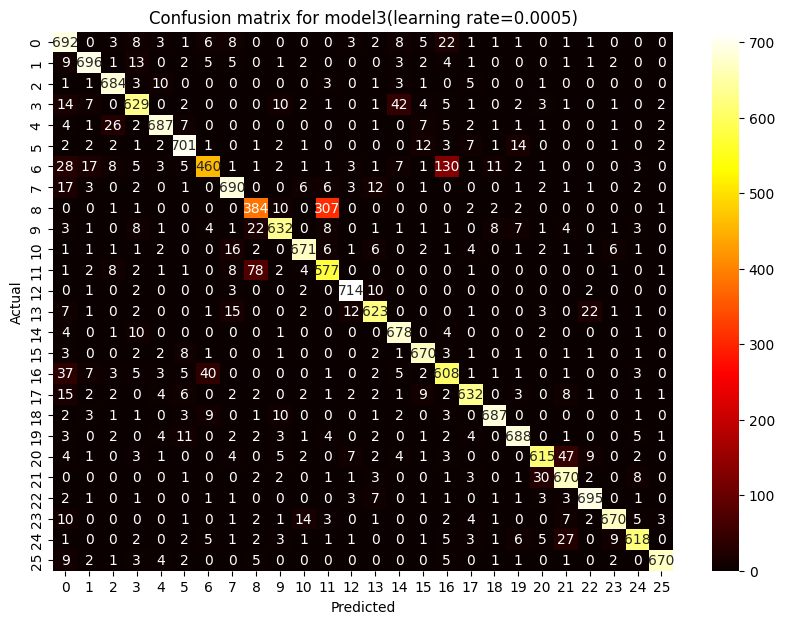

In [603]:
#plot for accuracy,f1,error for model1
for learning_rate in [0.005,0.003,0.001,0.0005]:
    file=open(f'model1_train_{learning_rate}.txt','r')
    lines=file.readlines()
    train_accuracy=[]
    train_f1=[]
    train_error=[]
    for line in lines:
        train_accuracy.append(float(line.split(' ')[3]))
        train_f1.append(float(line.split(' ')[5]))
        train_error.append(float(line.split(' ')[7]))

    #plot accuracy
    plt.plot(train_accuracy)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title(f'accuracy for model1(learning rate={learning_rate})')
    plt.savefig(f'model1_accuracy_{learning_rate}.png')

    #plot f1
    plt.clf()
    plt.plot(train_f1)
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.title(f'f1 for model1(learning rate={learning_rate})')
    plt.savefig(f'model1_f1_{learning_rate}.png')

    #plot error
    plt.clf()
    plt.plot(train_error)
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.title(f'error for model1(learning rate={learning_rate})')
    plt.savefig(f'model1_error_{learning_rate}.png')

    file=open(f'model1_validation_{learning_rate}.txt','r')
    lines=file.readlines()
    validation_accuracy=[]
    validation_f1=[]
    validation_error=[]
    for line in lines:
        validation_accuracy.append(float(line.split(' ')[3]))
        validation_f1.append(float(line.split(' ')[5]))
        validation_error.append(float(line.split(' ')[7]))

    #plot accuracy
    plt.clf()
    plt.plot(validation_accuracy)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title(f'validation accuracy for model1(learning rate={learning_rate})')
    plt.savefig(f'model1_validation_accuracy_{learning_rate}.png')

    #plot f1
    plt.clf()
    plt.plot(validation_f1)
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.title(f'validation f1 for model1(learning rate={learning_rate})')
    plt.savefig(f'model1_validation_f1_{learning_rate}.png')

    #plot error
    plt.clf()
    plt.plot(validation_error)
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.title(f'validation error for model1(learning rate={learning_rate})')
    plt.savefig(f'model1_validation_error_{learning_rate}.png')

    #plot confusion matrix using heatmap
    confusion = []
    row = []

    with open(f'model1_confusion_{learning_rate}.txt', 'r') as confusion_file:
        for line in confusion_file:
            # Remove newline character, brackets, and split line into numbers
            numbers = line.replace('[', '').replace(']', '').split()
            # Convert numbers to integers and add them to the current row
            row.extend([int(num) for num in numbers if num != ''])
            # If the line ends with ']', it's the end of the current row
            if ']' in line:
                # Add the current row to the confusion matrix and start a new row
                confusion.append(row)
                row = []
    
    # Convert confusion matrix to a numpy array
    confusion = np.array(confusion)
    plt.clf()
    # Plot the confusion matrix using matplotlib
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='hot')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion matrix for model1(learning rate={learning_rate})')
    plt.savefig(f'model1_confusion_{learning_rate}.png')


#plot for accuracy,f1,error for model2
for learning_rate in [0.005,0.003,0.001,0.0005]:
    file=open(f'model2_train_{learning_rate}.txt','r')
    lines=file.readlines()
    train_accuracy=[]
    train_f1=[]
    train_error=[]
    for line in lines:
        train_accuracy.append(float(line.split(' ')[3]))
        train_f1.append(float(line.split(' ')[5]))
        train_error.append(float(line.split(' ')[7]))

    #plot accuracy
    plt.clf()
    plt.plot(train_accuracy)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title(f'accuracy for model2(learning rate={learning_rate})')
    plt.savefig(f'model2_accuracy_{learning_rate}.png')

    #plot f1
    plt.clf()
    plt.plot(train_f1)
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.title(f'f1 for model2(learning rate={learning_rate})')
    plt.savefig(f'model2_f1_{learning_rate}.png')

    #plot error
    plt.clf()
    plt.plot(train_error)
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.title(f'error for model2(learning rate={learning_rate})')
    plt.savefig(f'model2_error_{learning_rate}.png')

    file=open(f'model2_validation_{learning_rate}.txt','r')
    lines=file.readlines()
    validation_accuracy=[]
    validation_f1=[]
    validation_error=[]
    for line in lines:
        validation_accuracy.append(float(line.split(' ')[3]))
        validation_f1.append(float(line.split(' ')[5]))
        validation_error.append(float(line.split(' ')[7]))

    #plot accuracy
    plt.clf()
    plt.plot(validation_accuracy)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title(f'validation accuracy for model2(learning rate={learning_rate})')
    plt.savefig(f'model2_validation_accuracy_{learning_rate}.png')

    #plot f1
    plt.clf()
    plt.plot(validation_f1)
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.title(f'validation f1 for model2(learning rate={learning_rate})')
    plt.savefig(f'model2_validation_f1_{learning_rate}.png')

    #plot error
    plt.clf()
    plt.plot(validation_error)
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.title(f'validation error for model2(learning rate={learning_rate})')
    plt.savefig(f'model2_validation_error_{learning_rate}.png')

    #plot confusion matrix using heatmap
    confusion = []
    row = []

    with open(f'model2_confusion_{learning_rate}.txt', 'r') as confusion_file:
        for line in confusion_file:
            # Remove newline character, brackets, and split line into numbers
            numbers = line.replace('[', '').replace(']', '').split()
            # Convert numbers to integers and add them to the current row
            row.extend([int(num) for num in numbers if num != ''])
            # If the line ends with ']', it's the end of the current row
            if ']' in line:
                # Add the current row to the confusion matrix and start a new row
                confusion.append(row)
                row = []

    # Convert confusion matrix to a numpy array
    confusion = np.array(confusion)
    plt.clf()
    # Plot the confusion matrix using matplotlib
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='hot')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion matrix for model2(learning rate={learning_rate})')
    plt.savefig(f'model2_confusion_{learning_rate}.png')


#plot for accuracy,f1,error for model3
for learning_rate in [0.005,0.003,0.001,0.0005]:
    file=open(f'model3_train_{learning_rate}.txt','r')
    lines=file.readlines()
    train_accuracy=[]
    train_f1=[]
    train_error=[]
    for line in lines:
        train_accuracy.append(float(line.split(' ')[3]))
        train_f1.append(float(line.split(' ')[5]))
        train_error.append(float(line.split(' ')[7]))

    #plot accuracy
    plt.clf()
    plt.plot(train_accuracy)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title(f'accuracy for model3(learning rate={learning_rate})')
    plt.savefig(f'model3_accuracy_{learning_rate}.png')

    #plot f1
    plt.clf()
    plt.plot(train_f1)
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.title(f'f1 for model3(learning rate={learning_rate})')
    plt.savefig(f'model3_f1_{learning_rate}.png')

    #plot error
    plt.clf()
    plt.plot(train_error)
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.title(f'error for model3(learning rate={learning_rate})')
    plt.savefig(f'model3_error_{learning_rate}.png')

    file=open(f'model3_validation_{learning_rate}.txt','r')
    lines=file.readlines()
    validation_accuracy=[]
    validation_f1=[]
    validation_error=[]
    for line in lines:
        validation_accuracy.append(float(line.split(' ')[3]))
        validation_f1.append(float(line.split(' ')[5]))
        validation_error.append(float(line.split(' ')[7]))

    #plot accuracy
    plt.clf()
    plt.plot(validation_accuracy)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title(f'validation accuracy for model3(learning rate={learning_rate})')
    plt.savefig(f'model3_validation_accuracy_{learning_rate}.png')

    #plot f1
    plt.clf()
    plt.plot(validation_f1)
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.title(f'validation f1 for model3(learning rate={learning_rate})')
    plt.savefig(f'model3_validation_f1_{learning_rate}.png')

    #plot error
    plt.clf()
    plt.plot(validation_error)
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.title(f'validation error for model3(learning rate={learning_rate})')
    plt.savefig(f'model3_validation_error_{learning_rate}.png')

    #plot confusion matrix using heatmap
    confusion = []
    row = []

    with open(f'model3_confusion_{learning_rate}.txt', 'r') as confusion_file:
        for line in confusion_file:
            # Remove newline character, brackets, and split line into numbers
            numbers = line.replace('[', '').replace(']', '').split()
            # Convert numbers to integers and add them to the current row
            row.extend([int(num) for num in numbers if num != ''])
            # If the line ends with ']', it's the end of the current row
            if ']' in line:
                # Add the current row to the confusion matrix and start a new row
                confusion.append(row)
                row = []

    # Convert confusion matrix to a numpy array
    confusion = np.array(confusion)
    plt.clf()
    # Plot the confusion matrix using matplotlib
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='hot')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion matrix for model3(learning rate={learning_rate})')
    plt.savefig(f'model3_confusion_{learning_rate}.png')
